In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
from torchvision import transforms as tt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn

# ##STDP rule for learning on device
local learning
focus on updatability, how can we update the model on small hardware
Add a new class to 
Try low class count - is object in path of robot? Does path need to change

Make algo to make memory efficient updates on model after already learning through backprop

In [2]:
from torchvision.ops import box_iou

In [3]:
import sys
sys.path.append("./mnist_sg_cnn")

In [4]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

### Notes
 - 2/14/2024
   - May be extremely memory intensive for image segmentation with local learning rule. Would have to return entire mask at each readout layer, 30000 params for even a small mask


In [5]:
#cache_dir = "./data/EVIMO/obj_det_cache"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 8 # T = 100
framerate = 200
epochs=0
output_size=(30, 40)
input_size=(480, 640)
num_classes = 25

dtype=torch.float

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [6]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dir: str,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dir = dir
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size
        self.length = np.load(self.dir + "/length.npy")

        
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()


        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        events = frame_transform(events)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        one_hot_mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        resized_mask = tt.functional.resize(one_hot_mask, self.output_size, antialias=True)
        
        return torch.from_numpy(events).to(torch.float), resized_mask.squeeze()

    def get_original_mask(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    def get_item(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        return item
    
    

In [7]:
dataset = EVIMOMask(dir="./data/EVIMO/left_cam/scene13_test5", output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [8]:
e, mask = dataset[0]

In [9]:
mask.shape, mask.unique()

(torch.Size([25, 30, 40]), tensor([0, 1]))

In [10]:
num_output_elements = torch.numel(mask)
mask.shape, num_output_elements

(torch.Size([25, 30, 40]), 30000)

In [11]:
e.shape

torch.Size([8, 1, 480, 640])

In [12]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
events, resized_mask = next(iter(trainloader))
events = events.to(device)
events.shape
events[0].shape

torch.Size([8, 1, 480, 640])

In [14]:
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(input_size[0] * input_size[1], 128)
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=61)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(128, output_size[0] * output_size[1] * num_classes)
        #self.conv2 = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=5)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, data):
        # Input data should be in format: Batch size, num_bins_per_frame, channel(1), x, y

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Record intermediate layer to find spikes in case of new labels
        spk1_rec = []

        current_batch_size = data.shape[0]
        
        data = data.transpose(0, 1) # Converting to num_bins_per_frame, batch_size, channel, x, y
        

        for step in range(num_bins_per_frame):
            x = data[step].view(current_batch_size, -1)
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            #print(spk1.shape)
            spk1_rec.append(spk1)
            
            spk2_rec.append(spk2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))
            mem2_rec.append(mem2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)



In [15]:
spk2, mem2, spk1 = net(events)
mem2.shape

torch.Size([8, 4, 25, 30, 40])

In [16]:
def compare_masks(dataset, index, time_step):
    data, mask = dataset[index]
    data = data.to(device).to(torch.float)
    data = data.reshape(1, 8, 1, 480, 640)
    
    spk_rec, mem_rec, _ = net(data)

    output_mask = spk_rec[time_step].squeeze().argmax(dim=0)
    mask = mask.argmax(dim=0)

    fig, axes = plt.subplots(ncols=2, nrows=1)
    axes.ravel()[0].imshow(output_mask.tolist())
    axes.ravel()[0].set_title("Model Generated")
    axes.ravel()[0].set_axis_off()
    axes.ravel()[1].imshow(mask.tolist())
    axes.ravel()[1].set_title("Original")
    axes.ravel()[1].set_axis_off()

    plt.show()

    return output_mask, mask

In [17]:
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=7e-2, betas=(0.9, 0.999))

# Outer training loop
net.train()
for epoch in range(epochs):
    iter_counter = 0
    
    #train_batch = iter(trainloader)
    train_batch = tqdm(iter(trainloader), desc=f"Epoch {epoch}")

    # Minibatch training loop
    acc_each_batch = []
    for data, masks in train_batch:
        data = data.to(device).to(torch.float)
        masks = masks.to(device).to(torch.float)

        #print(data.shape)
        #current_batch_size = data.shape[0]
        #print(data.view(batch_size, -1).shape)
        #print(masks.shape)

        # forward pass
        
        spk2_rec, mem2_rec, _ = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        acc_each_step = []
        for step in range(num_bins_per_frame):
            loss_val += loss(spk2_rec[step], masks)

        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    #print(f"Mean Pixel-Based Accuracy for all Steps & Batches: {mean(acc_each_batch)}")

    with torch.no_grad():
        net.eval()
        compare_masks(dataset, index=0, time_step=0)

In [18]:
torch.save(net, "evimo_img_segmentation_model")

In [19]:
25*30*40*batch_size

120000

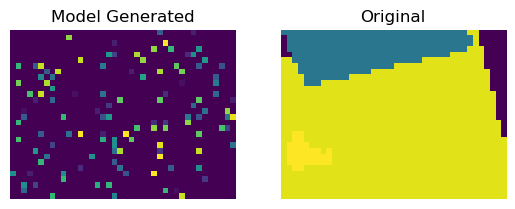

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0, 12,  ...,  0,  0,  0],
         [ 0,  0,  8,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]),
 tensor([[ 9,  9,  9,  ...,  0,  0,  0],
         [ 0,  9,  9,  ...,  0,  0,  0],
         [ 0,  9,  9,  ...,  0,  0,  0],
         ...,
         [22, 22, 22,  ..., 22, 22, 22],
         [22, 22, 22,  ..., 22, 22, 22],
         [22, 22, 22,  ..., 22, 22, 22]]))

In [20]:
compare_masks(dataset, index=0, time_step=0)

In [21]:
net.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'lif1.threshold', 'lif1.graded_spikes_factor', 'lif1.reset_mechanism_val', 'lif1.beta', 'fc2.weight', 'fc2.bias', 'lif2.threshold', 'lif2.graded_spikes_factor', 'lif2.reset_mechanism_val', 'lif2.beta'])

In [22]:
net.state_dict()["fc1.weight"].max()

tensor(0.0018)

In [23]:
net.state_dict()["fc1.weight"].min()

tensor(-0.0018)

In [24]:
net.state_dict()["fc1.bias"].max()

tensor(0.0018)

In [25]:
net.state_dict()["fc1.bias"].min()

tensor(-0.0018)

In [26]:
e, mask = dataset[0]
e.shape

e[0].view(1, -1).shape

torch.Size([1, 307200])

In [27]:
net = torch.load("evimo_img_segmentation_model").to(device)

In [28]:
# mem1 = net.lif1.init_leaky()
# mem2 = net.lif2.init_leaky()
# weights1 = net.state_dict()["fc1.weight"]
# weights2 = net.state_dict()["fc2.weight"]

# spk1_rec = [] # A list of lists of spike indexes.
# spk2_rec = []

# for step in range(num_bins_per_frame):
#     x = e[step].view(1, -1).to(device) # Batch size 1.

#     cur1 = net.fc1(x)
#     spk1, mem1 = net.lif1(cur1, mem1)
#     spk1_idx = spk1.nonzero(as_tuple=True)[1]
#     spk1_rec.append(spk1_idx)

#     cur2 = net.fc2(spk1)
#     spk2, mem2 = net.lif2(cur2, mem2)

#     spk2_idx = spk2.nonzero(as_tuple=True)[1]
#     spk2_rec.append(spk2_idx)

# do_stdp(weights2, spk1_rec, spk2_rec)

    
# """
# Initially train surrogate grad/backprop

# Learn after with stdp, so that we don't need specific labels

# How would we account for new labels, would require change in output space
#     More general labels

# """

    

In [29]:
weights1 = net.state_dict()["fc1.weight"]
weights2 = net.state_dict()["fc2.weight"]

In [30]:
def pre_stdp(weights, spk1_idxs, spk2_idxs):
    # BEFORE SPIKE WEIGHT INCREASE
    for main_step in range(0, num_bins_per_frame):
        current_spk2 = spk2_idxs[main_step]
        for i in range(0, main_step): # For each time step that passed:
            for input_spike_index in spk1_idxs[i]:
                # spk2_idx = list of indices
                # input_spike_index = single index
                # The locations defined by all spk2_idx and all spk1_idx are the weights that should be increased
                weights[current_spk2, input_spike_index] += 0.05*i

def post_stdp(weights, spk1_idxs, spk2_idxs):
    # AFTER SPIKE WEIGHT DECREASE
    for main_step in range(0, num_bins_per_frame):
        for current_spk2 in spk2_idxs[main_step]: # Retrieve only a single index of a spike in layer 2
    
            for secondary_step in range(main_step+1, num_bins_per_frame): 
                current_spk1s = spk1_idxs[secondary_step] # Retrieve all indices of spikes in layer 1 for the time step
        
                for input_spike_index in current_spk1s:
                    weights[current_spk2, input_spike_index] -= 0.05 * (main_step/secondary_step)


def do_stdp(weights, spk1_idxs, spk2_idxs):
    pre_stdp(weights, spk1_idxs, spk2_idxs)
    post_stdp(weights, spk1_idxs, spk2_idxs)
    
    
    

In [31]:
def cl_forward(data):
    # Input data should be in format: Batch size, num_bins_per_frame, channel(1), x, y

    # Initialize hidden states at t=0
    mem1 = net.lif1.init_leaky()
    mem2 = net.lif2.init_leaky()

    spk1_rec = []
    spk1_idxs = []
    
    # Record the final layer
    spk2_rec = []
    spk2_idxs = []
    mem2_rec = []

    current_batch_size = 1 #data.shape[0]
    
    #data = data.transpose(0, 1) # Converting to num_bins_per_frame, batch_size, channel, x, y

    for step in range(num_bins_per_frame):
        x = data[step].view(current_batch_size, -1)
        
        cur1 = net.fc1(x)
        spk1, mem1 = net.lif1(cur1, mem1)
        spk1_idx = spk1.nonzero(as_tuple=True)[1]
        spk1_idxs.append(spk1_idx)
    
        cur2 = net.fc2(spk1)
        spk2, mem2 = net.lif2(cur2, mem2)
        
        spk2_rec.append(spk2)
        mem2_rec.append(mem2)

        #print(spk2.shape)
    
        spk2_idx = spk2.nonzero(as_tuple=True)[1]
        #print(spk2_idx[0].unique())
        #print(spk2_idx.reshape(2, spk2_idx.shape[0])[0].unique())
        spk2_idxs.append(spk2_idx)

        


    do_stdp(weights2, spk1_idxs, spk2_idxs)

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [32]:
x, y = next(iter(trainloader))

In [33]:
x.shape

torch.Size([4, 8, 1, 480, 640])

In [34]:
x[0].shape

torch.Size([8, 1, 480, 640])

In [35]:
cl_forward(x[0])

KeyboardInterrupt: 

In [36]:
def pixel_finder(spk_rec):
    pixels = []
    t = torch.where(spk_rec == 0, True, False)
    for row in range(t.shape[0]):
        for col in range(t.shape[1]):
            if t[row][col].all(): # All 25 labels are 0
                pixels.append((row, col))
    return pixels

In [37]:
x[0].shape

torch.Size([8, 1, 480, 640])

In [38]:
x[0].unique()

tensor([0.0000e+00, 4.7685e-05, 9.5370e-05,  ..., 3.3286e+02, 3.4930e+02,
        4.1934e+02])

In [39]:
test = torch.zeros(4, 8, 1, 480, 640)
test.shape

torch.Size([4, 8, 1, 480, 640])

In [43]:
net.eval()
with torch.no_grad():
    spk1_idxs = []
    spk2_idxs = []
    data = test.to(device).to(torch.float)
    masks = y.to(device).to(torch.float)

    spk2_rec, mem2_rec, spk1_rec = net(data)
    
    for spk1 in spk1_rec:
        spk1_idx = spk1.nonzero(as_tuple=True)[1]
        spk1_idxs.append(spk1_idx)

    for spk2 in spk2_rec:
        spk2_idx = spk2.nonzero(as_tuple=True)[1]
        spk2_idxs.append(spk2_idx)

spk2_rec = spk2_rec[-1][0]
spk2_rec.shape

torch.Size([25, 30, 40])

In [45]:
pixels = pixel_finder(spk2_rec)

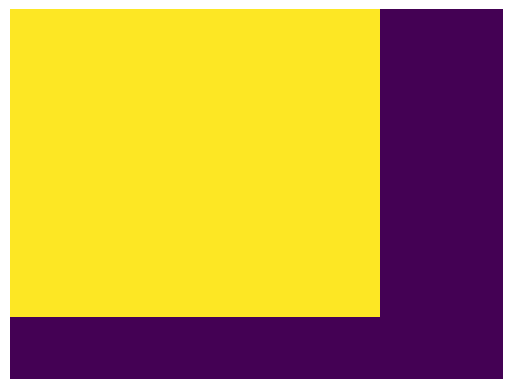

In [46]:
output_mask = spk2_rec.squeeze().argmax(dim=0)

for row, col in pixels:
    output_mask[row][col] = 2

fig, axes = plt.subplots(ncols=1, nrows=1)
axes.imshow(output_mask.tolist())
#axes.set_title("Model Generated")
axes.set_axis_off()

plt.show()

In [ ]:
weights2

In [47]:
weights2.shape

torch.Size([30000, 128])

In [ ]:
25*30*40

In [49]:
test = weights2.reshape((25, 30, 40, 128))
test.shape

torch.Size([25, 30, 40, 128])

In [48]:
weights1.shape

torch.Size([128, 307200])

In [41]:
spk1_rec.shape

torch.Size([8, 4, 128])